<a href="https://colab.research.google.com/github/JuanM-GG/modelos-tesis/blob/main/optimizacion_tasa_dilucion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Título: Optimización de la tasa de dilución en el biorreactor continuo mediante el método del descenso del gradiente

Autor: Juan Manuel Gutiérrez García 

Fecha: enero 2021

##Descripción del problema de optimización de la tasa de dilución en el biorreactor continuo

En esta sección se estudia el escenario donde se lleva a cabo la producción de biomasa y etanol en un biorreactor continuo en estado estacionario. Para realizar las simulaciones del biorreactor continuo se emplean los parámetros cinéticos de las levaduras  *Isstchenkia terrícola*, *Kluyveromyces marxianus*, *Pichia kluyveri*, *Zygosaccharomyces bailii* y *Zygosaccharomyces rouxi* obtenidos mediante la optimización paramétrica. En un biorreactor, continuo que es operado bajo condiciones estacionarias, es importante conocer el valor de la tasa de dilución que permite maximizar la producción de biomasa y producto por unidad de tiempo, es decir, la productividad. A través del modelo que se plantea para describir el proceso se obtienen los valores de la tasa de alimentación óptima de cada levadura, así como los valores de máxima productividad de biomasa y etanol correspondientes.

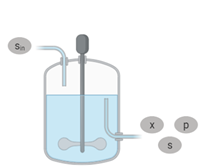

Figura 1. Esquema del biorreactor continuo para la optimización de la tasa de dilución. En un biorreactor continuo el flujo de alimentación y el flujo de salida del biorreactor son iguales. Por esta razón el volumen permanece constante. Además, se asume que el biorreactor se opera en condiciones estacionarias por lo cual la concentración de biomasa, sustrato y etanol en el biorreactor permanencen constantes.

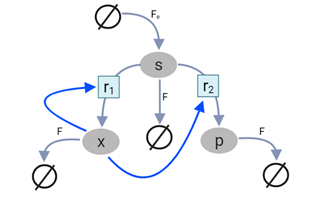

Figura 2. Red para describir el proceso del biorreactor continuo. Aquí se observan los flujos de materia hacia y desde el biorreactor, así como las reacciones que se consideran ocurren en el interiror del biorreactor (flechas grises). Además, es posible apreciar el efecto positivo de la biomasa sobre la producción de etanol y su propia producción (flechas azules).

## Modelo matemático para la optimización de la tasa de dilución

En un biorreactor continuo la productividad de biomasa se puede expresar como la concentración de biomasa que sale del biorreactor por unidad de tiempo. Dado que se asumen condiciones estacionarias, la productividad de biomasa se puede expresar de la siguiente manera

\begin{equation}
P_x(D, \bar{x}) = D \bar{x}
\end{equation}


donde $\bar{x}$ representa la concentración de biomasa en estado estacionario y $D$ representa la tasa de dilución. 

De forma similar, la productividad de etanol en en condiciones de estado estacionario se expresa como

\begin{equation}
P_e(D, \bar{p}) = D \bar{p}
\end{equation}

donde $\bar{p}$ es la concentración de etanol en estado estacionario. 

Considerando el estado de equilibrio no trivial $ss_2$

$$\bar{x} = Y_{xs} (s_f - \bar{s})$$

$$\bar{s} = \frac{D k_s}{\mu_{max} - D}$$

$$\bar{p} = Y_{px}\bar{x}$$

Tenemos 

\begin{equation}
P_x(D) = D Y_{xs} (s_f - \frac{D k_s}{\mu_{max} - D})
\end{equation}

y

\begin{equation}
P_p(D) = D Y_{px}Y_{xs} (s_f - \frac{D k_s}{\mu_{max} - D})
\end{equation}

En realidad las dos funciones objetivo son equivalentes, ya que una es un múltiplo de la otra. Por esta razón, ambas poseen el mismo valor óptimo de la tasa de dilución, de tal manera que basta con optimizar cualquiera de ellas para conocer el valor de la tasa de dilución que genere la mayor productividad de biomasa y etanol. A continuación, se emplea \eqref{eq:opt_bio2_cont} en la optimización.

Considerando lo anterior, el problema de optimización se enuncia como sigue 

Maximizar: 

\begin{equation}
P_x(D) = D Y_{xs} (s_f - \frac{D k_s}{\mu_{max} - D})
\end{equation}

Sujeto a: 

\begin{equation}
0 < D < D^{*}
\end{equation}


La restricción \eqref{eq:rest_opt_tasa} se obtuvo a partir del análisis de estabilidad realizado. Por esta razón es importante llevar a cabo una análisis de estabilidad antes de determinar las condiciones óptimas de operación. 

## Método del gradiente

In [1]:
# cargar librerías
library(ggplot2)
library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
# valor arbitrario de parámetros
p <- c(mu_max = 1.2, ks = 180, Yxs = 0.1, Ypx = 2,sf = 80, D = 0.01)

In [3]:
#@title establecer función objetivo 
# aquí x representa la variable a optimizar, osea D 
productivity_func <- function(x, p) {
  with(as.list(p), {

    productivity_x = x*Yxs*(sf - x*ks/(mu_max - x))
    productivity_p = Ypx*productivity_x
    return(list(productivity_x = productivity_x, productivity_p = productivity_p))

  })
}

In [4]:
# valores de D a evaluar
x <- seq(0,0.25,len=100)

In [5]:
# obtener productividad
productivity <- productivity_func(x,p)

In [6]:
#@title función para generar datos con productividad
get_data_productivity <- function(productivity) {
    # guardar resultados 
    out <- data.frame(D = rep(x,2), productivity = c(productivity$productivity_x, 
                                    productivity$productivity_p), 
                                    var = rep(factor(c("x","p")), each = length(x)))
    return(out)
}

In [7]:
out <- get_data_productivity(productivity)
head(out)

,D,productivity,var
,<dbl>,<dbl>,<fct>
1,0.000000000,0.00000000,x
2,0.002525253,0.02010616,x
3,0.005050505,0.04001981,x
4,0.007575758,0.05973971,x
5,0.010101010,0.07926463,x
6,0.012626263,0.09859333,x


In [8]:
#@title función para graficas la productividad
plot_productivity <- function(out) {
    ggplot(out, aes(x = D, y = productivity, color = var)) +
    geom_line(lty = 1, lwd = 1) +
    ylab("Productividad de biomasa (g/L h)") +
    xlab("D (1/h)") +
    scale_color_discrete(name = "", labels = c("etanol", "biomasa")) +
    theme_bw() +
    theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=20,   ),
            legend.position = c(0.80, 0.80), 
            legend.background = element_rect(fill=NA))
            
}

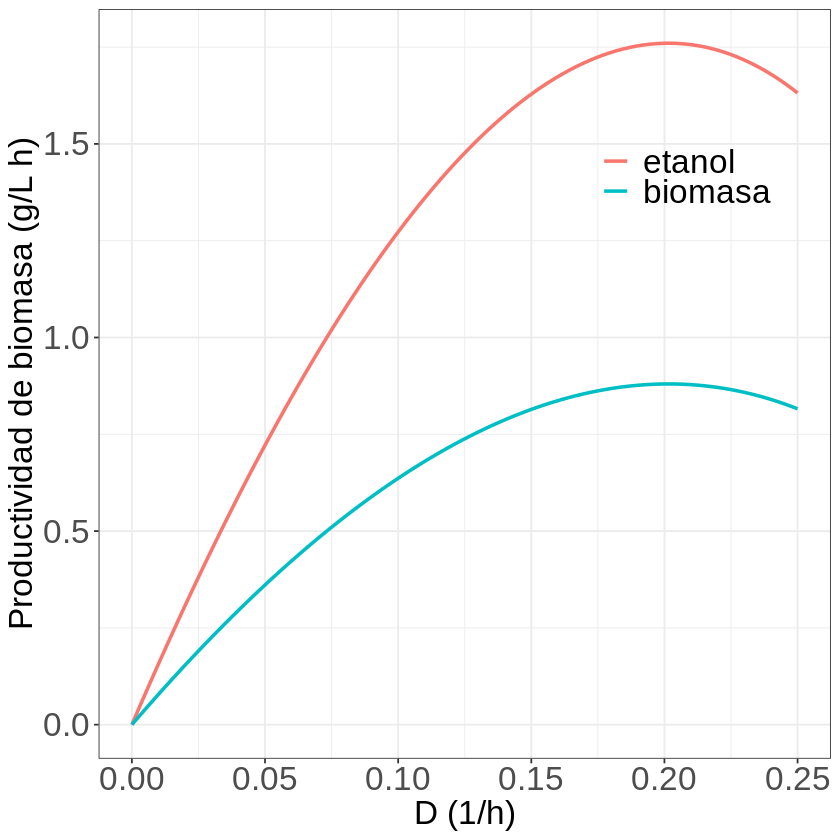

In [9]:
plot_productivity(out)

In [10]:
#@title función para obtener D_opt para un conjunto de parametros 
D_opt <- function(p) {
    with(as.list(p), {

        D_opt = mu_max*sf/(2*ks)

        return(D_opt)
    })
}

In [11]:
# @title derivada de la función de productividad 
deriv_productivity_func <- function(x, p) {
    with(as.list(p),{
        df = Yxs*(sf - ks*x*((2*mu_max - x)/(mu_max-x)^2))
        return(df)
    })
}

In [12]:
deriv_productivity_func(x = 0.43, p = p)

[1] -17.71732

In [13]:
#@title método de ascenso del gradiente 
gradient_method <- function(x0,alpha,eps,p) {
    grad = deriv_productivity_func(x0,p)
    while(abs(grad) > eps) {
        x = x0 + alpha*grad # sumar porque se busca subir por la colina
        x0 = x
        grad = deriv_productivity_func(x0,p)
    }
    return(list(sol = x, grad = grad))
}

In [14]:
x0 <- 0.05
alpha <- 0.01
eps <- 0.01
sol <- gradient_method(x0, alpha, eps, p)
productivity_opt <- productivity_func(sol$sol, p)

In [15]:
print(sol)
print(productivity_opt)

$sol
[1] 0.2013876

$grad
[1] 0.007918772

$productivity_x
[1] 0.880061

$productivity_p
[1] 1.760122



In [16]:
#@title función para graficar productividad con tasa de alimentación óptima
plot_productivity_Dopt <- function(out, sol, productivity) {
    # mostrar resultados 
    optima = data.frame(D = rep(sol$sol,2),
    productivity = c(productivity$productivity_x,productivity$productivity_p))

    ggplot(out, aes(x = D, y = productivity, color = var)) +
    geom_line(lty = 1, lwd = 1) +
    geom_vline(xintercept = sol$sol, color = "skyblue", lwd = 2, lty = 2) +
    geom_point(data = optima, col = "brown", cex = 5) +
    ylab("Productividad de biomasa (g/Lh)") +
    xlab("D (1/h)") +
    scale_color_discrete(name = "", labels = c("etanol", "biomasa")) +
    theme_bw() +
    theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=20,   ),
            legend.position = c(0.80, 0.80), 
            legend.background = element_rect(fill=NA))
}

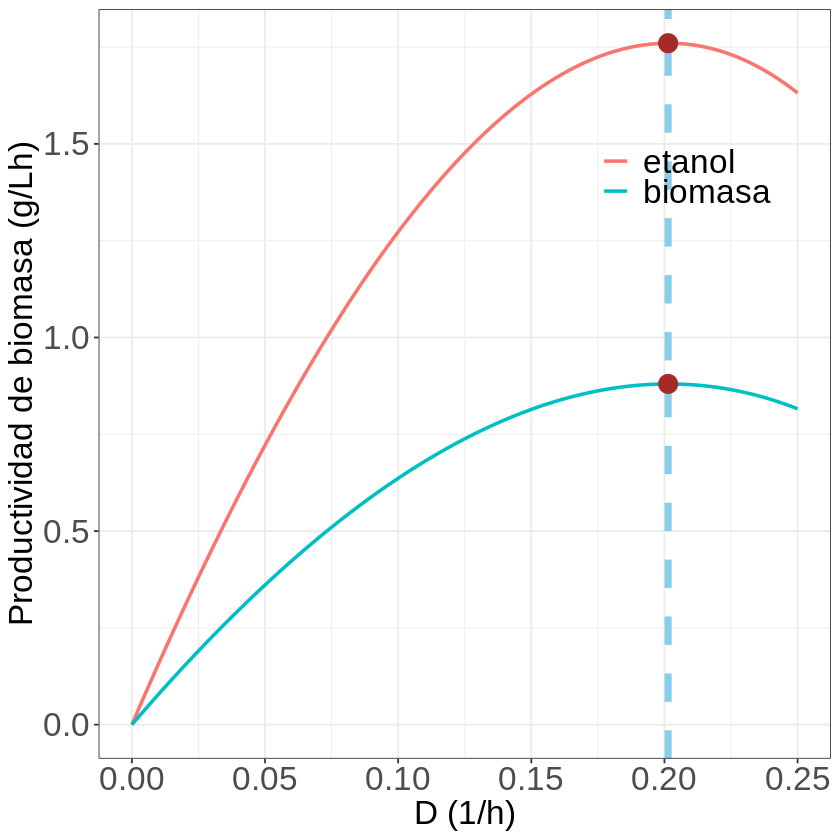

In [17]:
plot_productivity_Dopt(out,sol, productivity_opt)

### Valor límite para $D$

In [163]:
# función para calcular D*
D_bif <- function(p) {
  with(as.list(p), {

    D = mu_max*sf/(ks + sf)

    return(D)
  })
}

# Optimización con parámetros de *Isstchenkia terrícola*

Debemos proponer un valor para el parámetros $s_f$. Establezcamos $s_f = 80\ g/L$

In [19]:
# parámetros óptimos de Isstchenkia terrícola
p_it <- c(mu_max = 1.4536067, ks = 284.3997206, Yxs = 0.1092001, Ypx = 7.0414839, sf = 80)

In [20]:
# valor superior para D
D_bif(p_it)

[1] 0.3191236

In [21]:
# obtener productividad
productivity_it <- productivity_func(x,p_it)

# generar los datos para la gráfica
out_it <- get_data_productivity(productivity_it)
head(out_it)

,D,productivity,var
,<dbl>,<dbl>,<fct>
1,0.000000000,0.00000000,x
2,0.002525253,0.02192415,x
3,0.005050505,0.04357438,x
4,0.007575758,0.06494927,x
5,0.010101010,0.08604736,x
6,0.012626263,0.10686721,x


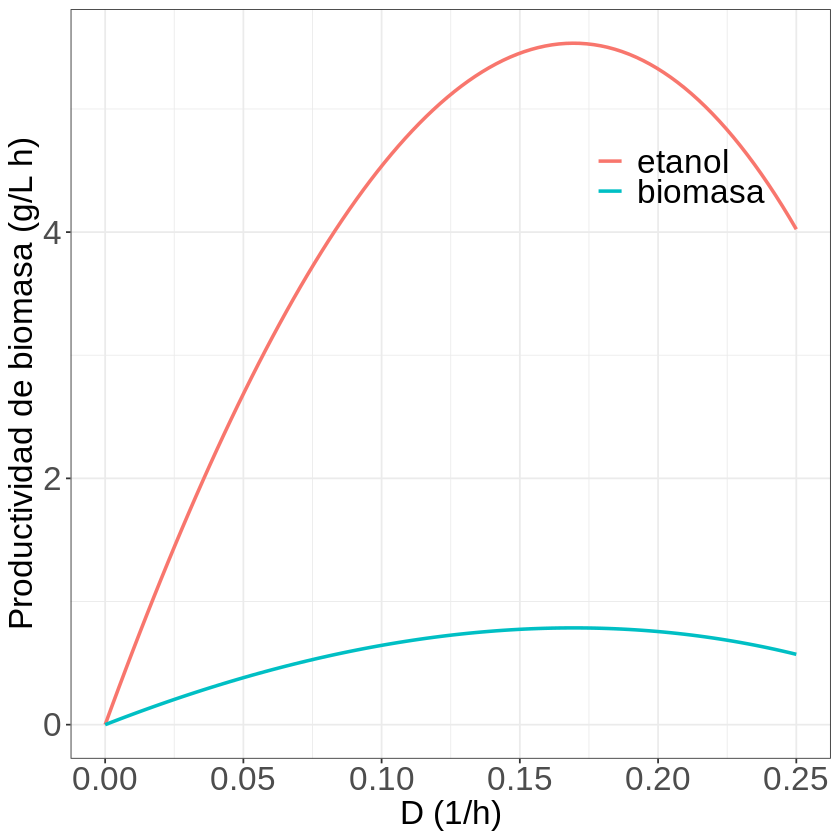

In [22]:
plot_productivity(out_it)

### Realizar optimización 

In [23]:
sol_it <- gradient_method(x0, alpha, eps, p_it)
productivity_opt_it <- productivity_func(sol_it$sol, p_it)

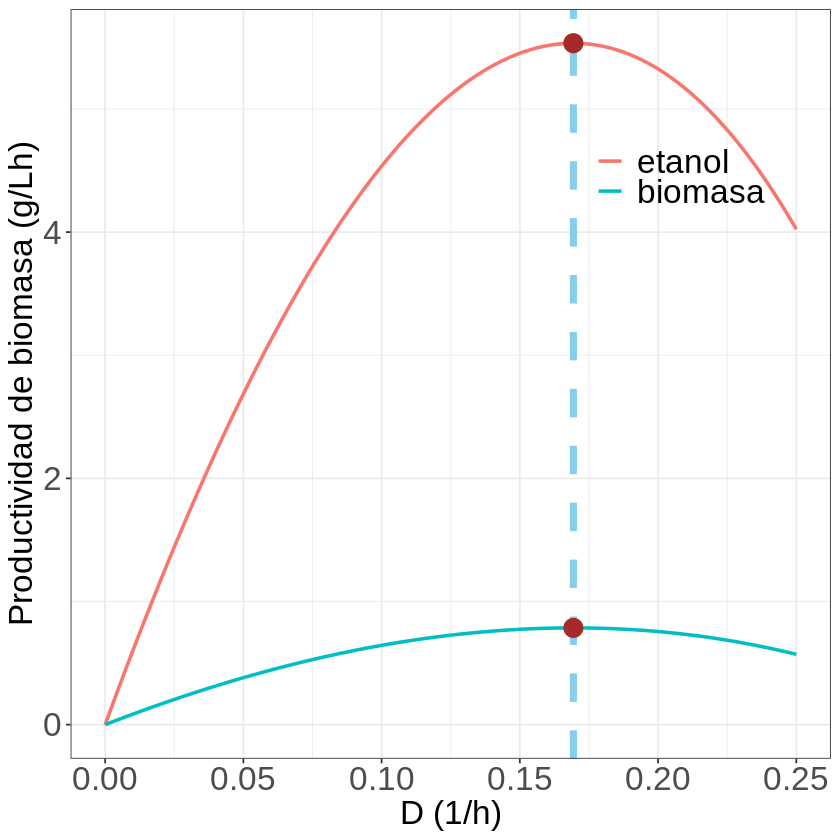

In [24]:
plot_productivity_Dopt(out_it,sol_it, productivity_opt_it)

# Optimización con parámetros de *Kluyveromyces marxianus*

In [25]:
# parámetros óptimo para Kluyveromyces marxianus
p_km <- c(mu_max = 1.0110607, ks = 353.3425303, Yxs = 0.1301708, Ypx = 4.9448320, sf = 80)      

In [26]:
D_bif(p_km)

[1] 0.1866534

In [27]:
# obtener productividad
productivity_km <- productivity_func(x,p_km)

# generar los datos para la gráfica
out_km <- get_data_productivity(productivity_km)
head(out_km)

,D,productivity,var
,<dbl>,<dbl>,<fct>
1,0.000000000,0.00000000,x
2,0.002525253,0.02600631,x
3,0.005050505,0.05142805,x
4,0.007575758,0.07626082,x
5,0.010101010,0.10050015,x
6,0.012626263,0.12414154,x


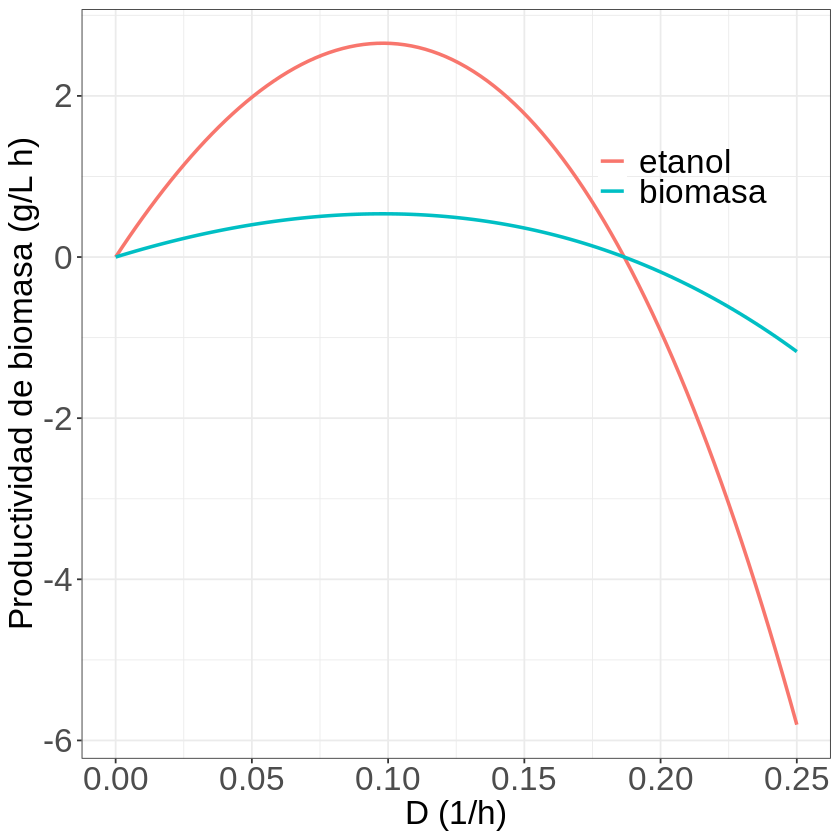

In [28]:
plot_productivity(out_km)

### Realizar optimización 

In [29]:
sol_km <- gradient_method(x0, alpha, eps, p_km)
productivity_opt_km <- productivity_func(sol_km$sol, p_km)

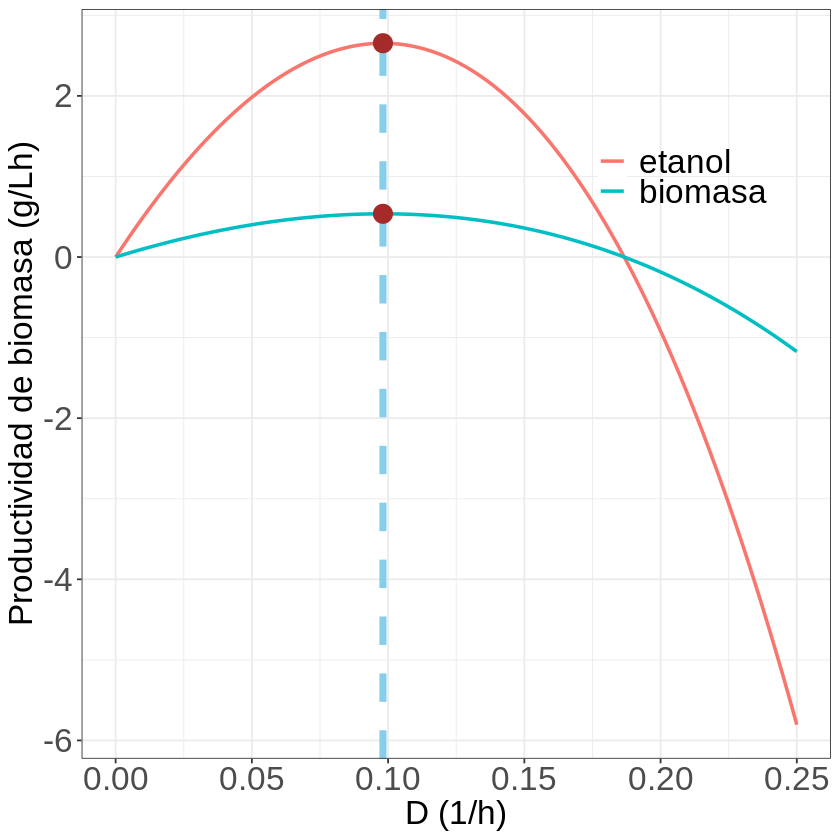

In [30]:
plot_productivity_Dopt(out_km, sol_km,productivity_opt_km)

# Optimización con parámetros de *Pichia kluyveri*

In [31]:
# parámetros óptimos de Pichia kluyveri
p_pk <- c(mu_max = 0.6588448, ks = 366.8216124, Yxs = 0.1032014, Ypx = 3.8650679, sf = 80)  

In [32]:
D_bif(p_pk)

[1] 0.1179611

In [33]:
# obtener productividad
productivity_pk <- productivity_func(x,p_pk)

# generar los datos para la gráfica
out_pk <- get_data_productivity(productivity_pk)
head(out_pk)

,D,productivity,var
,<dbl>,<dbl>,<fct>
1,0.000000000,0.00000000,x
2,0.002525253,0.02048095,x
3,0.005050505,0.04022057,x
4,0.007575758,0.05921026,x
5,0.010101010,0.07744123,x
6,0.012626263,0.09490462,x


### Realizar optimización 

In [34]:
sol_pk <- gradient_method(x0,alpha,eps,p_pk)
productivity_opt_pk <- productivity_func(sol_pk$sol, p_pk)

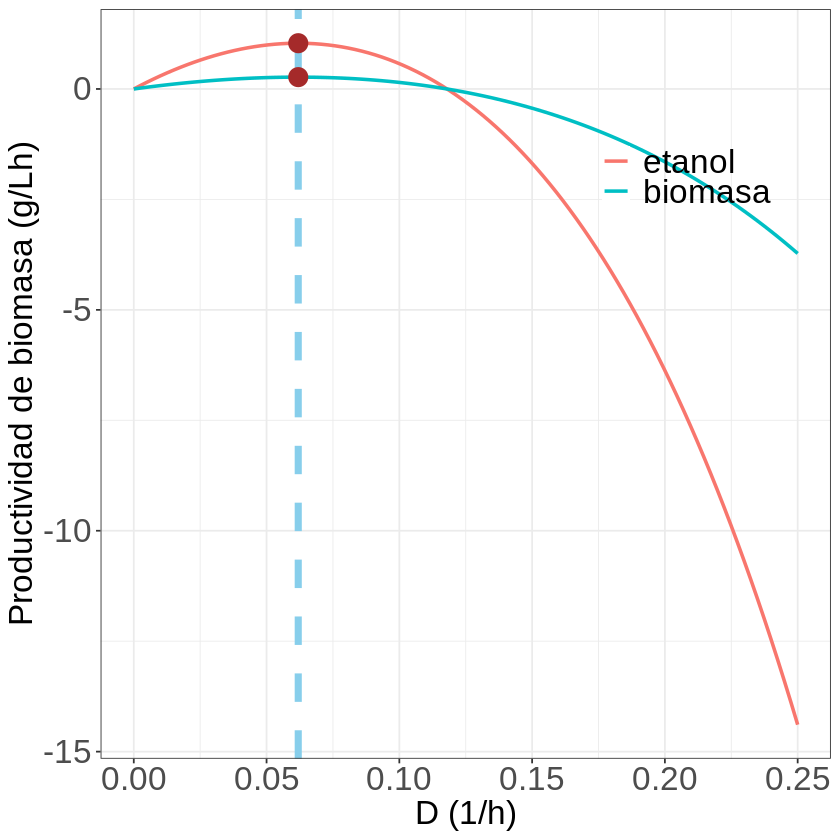

In [35]:
plot_productivity_Dopt(out_pk, sol_pk,productivity_opt_pk)

# Optimización con parámetros de *Zygosaccharomyces bailii*

In [36]:
# parámetros óptimos de Zygosaccharomyces bailii
p_zb <- c(mu_max = 1.1682471, ks = 300.1541664, Yxs = 0.1171282, Ypx = 4.9301197, sf = 80)  

In [37]:
D_bif(p_zb)

[1] 0.245847

In [38]:
# obtener productividad
productivity_zb <- productivity_func(x,p_zb)

# generar los datos para la gráfica
out_zb <- get_data_productivity(productivity_zb)
head(out_zb)

,D,productivity,var
,<dbl>,<dbl>,<fct>
1,0.000000000,0.00000000,x
2,0.002525253,0.02346994,x
3,0.005050505,0.04655358,x
4,0.007575758,0.06924839,x
5,0.010101010,0.09155183,x
6,0.012626263,0.11346133,x


### Realizar optimización 

In [39]:
sol_zb <- gradient_method(x0, alpha, eps, p_zb)
productivity_opt_zb <- productivity_func(sol_zb$sol, p_zb)

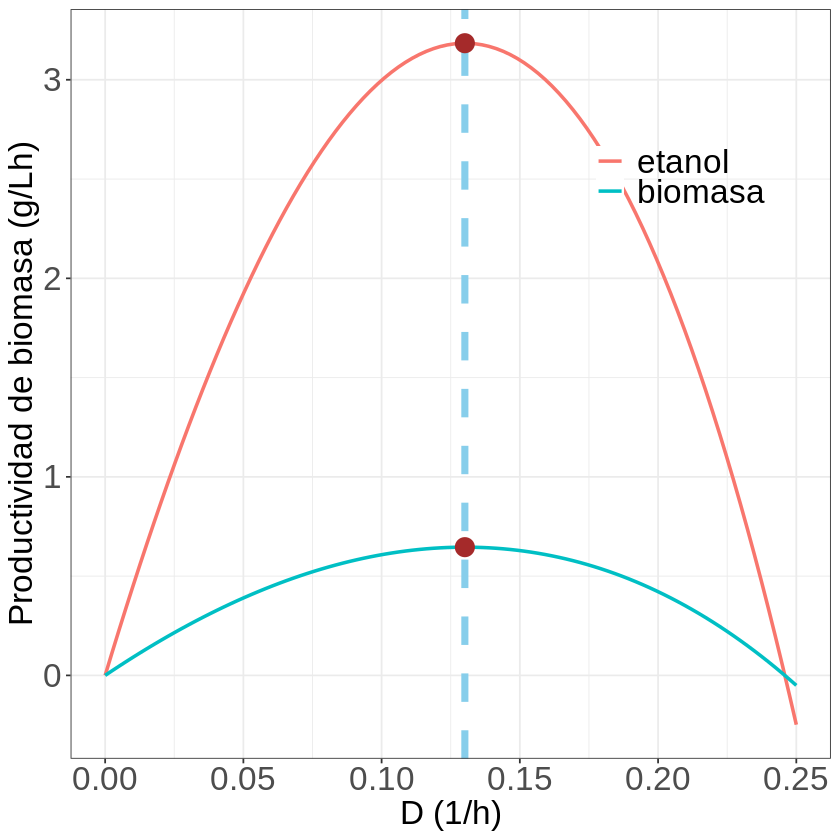

In [40]:
plot_productivity_Dopt(out_zb, sol_zb, productivity_opt_zb)

# Optimización con parámetros de *Zigosaccharomyces rouxi*

In [41]:
# parámetros óptimos de Zygosaccharomyces bailii
p_zr <- c(mu_max = 0.5003527, ks = 250.9052285, Yxs = 0.1950366, Ypx = 3.1550382, sf = 80) 

In [42]:
D_bif(p_zr)

[1] 0.1209658

In [43]:
# obtener productividad
productivity_zr <- productivity_func(x, p_zr)

# generar datos para la gráfica
out_zr <- get_data_productivity(productivity = productivity_zr)
head(out_zr)

,D,productivity,var
,<dbl>,<dbl>,<fct>
1,0.000000000,0.00000000,x
2,0.002525253,0.03877449,x
3,0.005050505,0.07628252,x
4,0.007575758,0.11250462,x
5,0.010101010,0.14742091,x
6,0.012626263,0.18101112,x


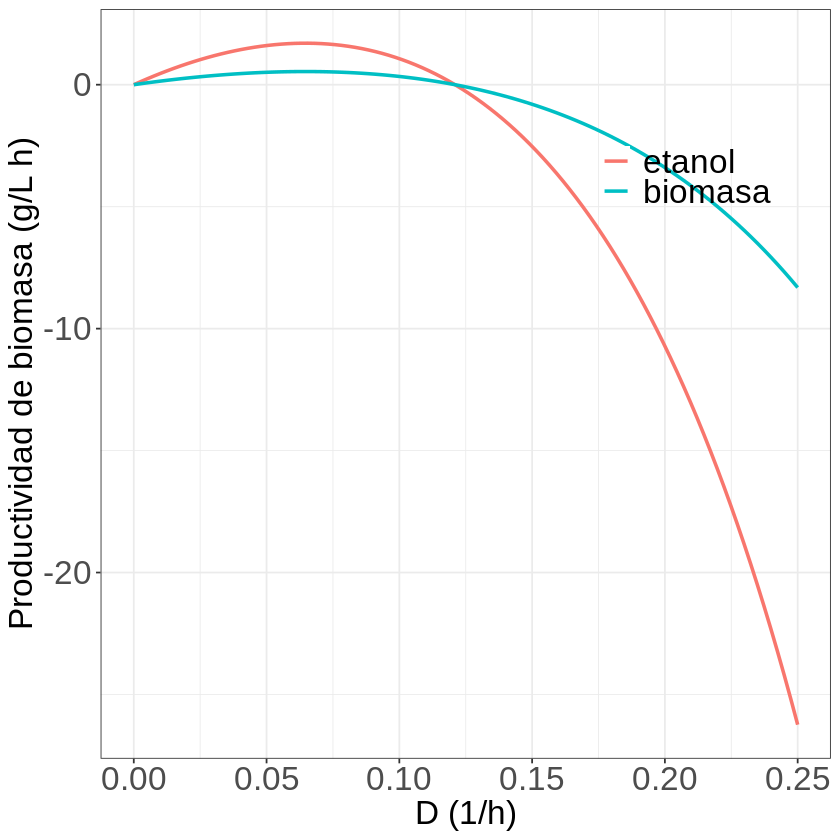

In [44]:
plot_productivity(out_zr)

### Realizar optimización 

In [45]:
sol_zr <- gradient_method(x0, alpha, 0.1, p_zr)
productivity_opt_zr <- productivity_func(sol_zr$sol, p_zr)

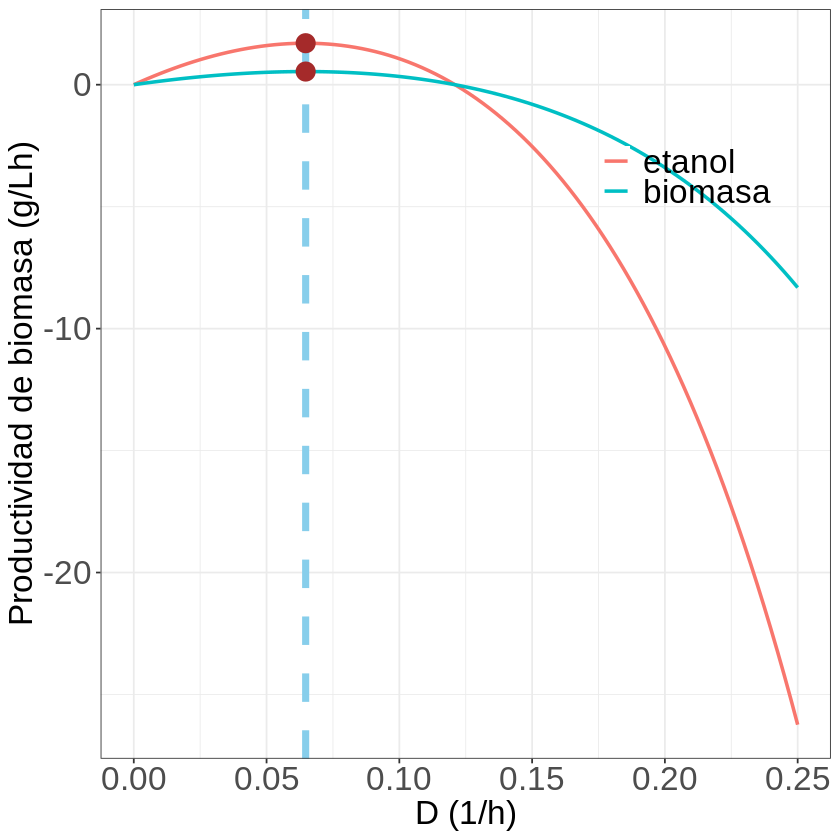

In [46]:
plot_productivity_Dopt(out_zr, sol_zr,productivity_opt_zr)

# Resultados 

Tabla 1. Valores de $D^{opt}$, $\dot{m}_x$ y $\dot{m}_p$ obtenido para las diferentes levaduras 

| levadura | $D^{opt}$ | $D^{*}$ | $\dot{m}_x$ | $\dot{m}_p$ |
|:---:|:---:|:---:|:---:|:---:|
| Isstchenkia terrícola | $0.169\ h^{-1}$ | $0.319\ h^{-1}$ |$0.785\ g/h$ | $5.5339\ g/h$ |
| Kluyveromyces marxianus | $0.0981\ h^{-1}$ |$0.1866\ h^{-1}$  |$0.536\ g/h$ |$2.654\ g/h$ |
| Pichia kluyveri | $0.0619\ h^{-1}$ |$0.117\ h^{-1}$  |$0.268\ g/h$ |$1.036\ g/h$ |
| Zygosaccharomyces bailii | $0.130\ h^{-1}$ |$0.245\ h^{-1}$  |$0.645\ g/h$ |$3.184\ g/h$ |
| Zigosaccharomyces rouxi |$0.0647\ h^{-1}$ |$0.120
\ h^{-1}$  |$0.539\ g/h$ |$1.7015\ g/h$ |

In [164]:
# @title D límite
cat("Isstchenkia terrícola \n")
cat("D_opt:", D_bif(p_it), "(1/h) \n\n")
cat("Kluyveromyces marxianus \n")
cat("D_opt:", D_bif(p_km), "(1/h) \n\n")
cat("Pichia kluyveri \n")
cat("D_opt:", D_bif(p_pk), "(1/h) \n\n")
cat("Zygosaccharomyces bailii \n")
cat("D_opt:", D_bif(p_zb), "(1/h) \n\n")
cat("{Zigosaccharomyces rouxi \n")
cat("D_opt:", D_bif(p_zr), "(1/h)")

Isstchenkia terrícola 
D_opt: 0.3191236 (1/h) 

Kluyveromyces marxianus 
D_opt: 0.1866534 (1/h) 

Pichia kluyveri 
D_opt: 0.1179611 (1/h) 

Zygosaccharomyces bailii 
D_opt: 0.245847 (1/h) 

{Zigosaccharomyces rouxi 
D_opt: 0.1209658 (1/h)

In [49]:
#@title mp máximo 
cat("Isstchenkia terrícola \n")
cat("mp_max: ", productivity_opt_it$productivity_p, "g/Lh \n\n")
cat("Kluyveromyces marxianus \n")
cat("mp_max: ", productivity_opt_km$productivity_p, "g/Lh \n\n")
cat("Pichia kluyveri \n")
cat("mp_max: ", productivity_opt_pk$productivity_p, "g/Lh \n\n")
cat("Zygosaccharomyces bailii \n")
cat("mp_max: ", productivity_opt_zb$productivity_p, "g/Lh \n\n")
cat("Zigosaccharomyces rouxi \n")
cat("mp_max: ", productivity_opt_zr$productivity_p, "g/Lh")

Isstchenkia terrícola 
mp_max:  5.533932 g/Lh 

Kluyveromyces marxianus 
mp_max:  2.654108 g/Lh 

Pichia kluyveri 
mp_max:  1.036084 g/Lh 

Zygosaccharomyces bailii 
mp_max:  3.184248 g/Lh 

Zigosaccharomyces rouxi 
mp_max:  1.701502 g/Lh

In [161]:
#@title D óptimos 
cat("Isstchenkia terrícola \n")
cat("D_opt:", sol_it$sol, "(1/h) \n\n")
cat("Kluyveromyces marxianus \n")
cat("D_opt:", sol_km$sol, "(1/h) \n\n")
cat("Pichia kluyveri \n")
cat("D_opt:", sol_pk$sol, "(1/h) \n\n")
cat("Zygosaccharomyces bailii \n")
cat("D_opt:", sol_zb$sol, "(1/h) \n\n")
cat("{Zigosaccharomyces rouxi \n")
cat("D_opt:", sol_zr$sol, "(1/h)")

Isstchenkia terrícola 
D_opt: 0.169363 (1/h) 

Kluyveromyces marxianus 
D_opt: 0.09810681 (1/h) 

Pichia kluyveri 
D_opt: 0.0619346 (1/h) 

Zygosaccharomyces bailii 
D_opt: 0.1301124 (1/h) 

{Zigosaccharomyces rouxi 
D_opt: 0.06472541 (1/h)

In [48]:
#@title mx máximo 
cat("Isstchenkia terrícola \n")
cat("mx_max: ", productivity_opt_it$productivity_x, "g/Lh \n\n")
cat("Kluyveromyces marxianus \n")
cat("mx_max: ", productivity_opt_km$productivity_x, "g/Lh \n\n")
cat("Pichia kluyveri \n")
cat("mx_max: ", productivity_opt_pk$productivity_x, "g/Lh \n\n")
cat("Zygosaccharomyces bailii \n")
cat("mx_max: ", productivity_opt_zb$productivity_x, "g/Lh \n\n")
cat("Zigosaccharomyces rouxi \n")
cat("mx_max: ", productivity_opt_zr$productivity_x, "g/Lh")

Isstchenkia terrícola 
mx_max:  0.7859042 g/Lh 

Kluyveromyces marxianus 
mx_max:  0.5367438 g/Lh 

Pichia kluyveri 
mx_max:  0.2680636 g/Lh 

Zygosaccharomyces bailii 
mx_max:  0.6458765 g/Lh 

Zigosaccharomyces rouxi 
mx_max:  0.5392968 g/Lh

### Gráfica de barras con tasas de dilución óptimas 

In [50]:
data_Dopt <- data.frame(lev = c("IT","KM","PK","ZB","ZR"),
                    Dopt = c(sol_it$sol,sol_km$sol,sol_pk$sol,sol_zb$sol,sol_zr$sol))

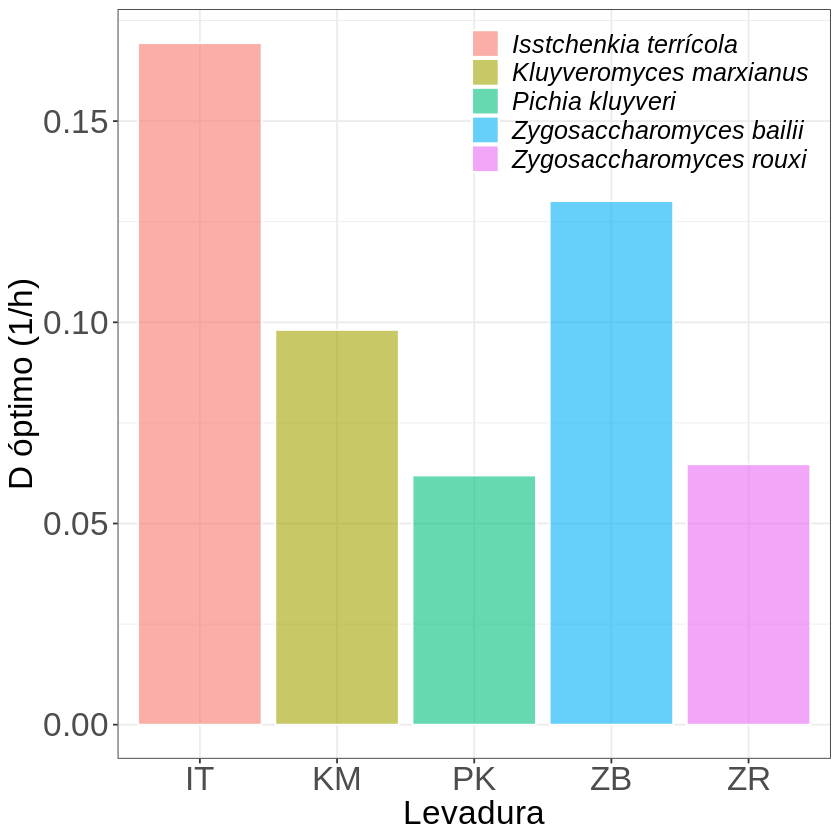

In [51]:
ggplot(data=data_Dopt, aes(x=lev, y=Dopt, fill = lev)) +
  geom_bar(stat="identity", color="white", alpha = 0.6) +
  xlab("Levadura") +
  ylab("D óptimo (1/h)") +
  scale_fill_discrete(name = "", labels = c("Isstchenkia terrícola", 
  "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
  "Zygosaccharomyces rouxi")) +
  theme_bw() +
  theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.73, 0.90), 
            legend.background = element_rect(fill=NA))
            

In [58]:
ggplot(data = out_it, aes(x = ))

[1] 0.000000000 0.002525253 0.005050505 0.007575758 0.010101010 0.012626263
  [7] 0.015151515 0.017676768 0.020202020 0.022727273 0.025252525 0.027777778
 [13] 0.030303030 0.032828283 0.035353535 0.037878788 0.040404040 0.042929293
 [19] 0.045454545 0.047979798 0.050505051 0.053030303 0.055555556 0.058080808
 [25] 0.060606061 0.063131313 0.065656566 0.068181818 0.070707071 0.073232323
 [31] 0.075757576 0.078282828 0.080808081 0.083333333 0.085858586 0.088383838
 [37] 0.090909091 0.093434343 0.095959596 0.098484848 0.101010101 0.103535354
 [43] 0.106060606 0.108585859 0.111111111 0.113636364 0.116161616 0.118686869
 [49] 0.121212121 0.123737374 0.126262626 0.128787879 0.131313131 0.133838384
 [55] 0.136363636 0.138888889 0.141414141 0.143939394 0.146464646 0.148989899
 [61] 0.151515152 0.154040404 0.156565657 0.159090909 0.161616162 0.164141414
 [67] 0.166666667 0.169191919 0.171717172 0.174242424 0.176767677 0.179292929
 [73] 0.181818182 0.184343434 0.186868687 0.189393939 0.191919192 0.194444444
 [79] 0.196969697 0.199494949 0.202020202 0.204545455 0.207070707 0.209595960
 [85] 0.212121212 0.214646465 0.217171717 0.219696970 0.222222222 0.224747475
 [91] 0.227272727 0.229797980 0.232323232 0.234848485 0.237373737 0.239898990
 [97] 0.242424242 0.244949495 0.247474747 0.250000000

### Gráfica de barras para la producción de biomasa 

In [53]:
data_mx <- data.frame(lev = c("IT","KM","PK","ZB","ZR"),
                    mx = c(productivity_opt_it$productivity_x,productivity_opt_km$productivity_x,
                           productivity_opt_pk$productivity_x,productivity_opt_zr$productivity_x,
                           productivity_opt_zb$productivity_x))

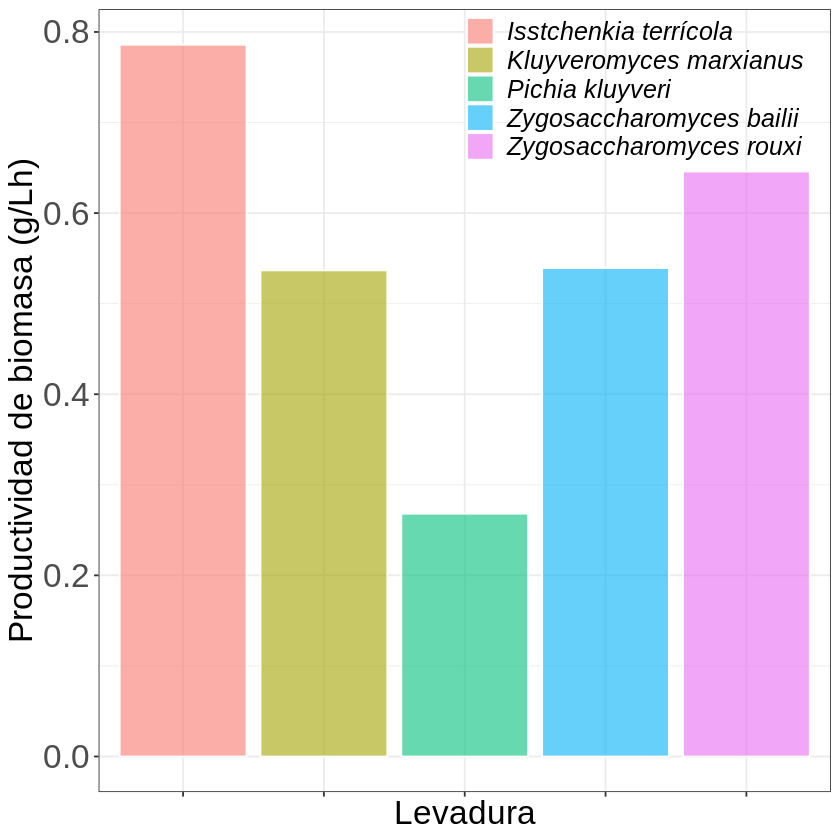

In [166]:
ggplot(data=data_mx, aes(x=lev, y=mx, fill = lev)) +
  geom_bar(stat="identity", color="white", alpha = 0.6) +
  xlab("Levadura") +
  ylab("Productividad de biomasa (g/Lh)") +
  scale_fill_discrete(name = "", labels = c("Isstchenkia terrícola", 
  "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
  "Zygosaccharomyces rouxi")) +
  theme_bw() +
  theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            axis.text.x=element_blank(),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.73, 0.92), 
            legend.background = element_rect(fill=NA))
            

### Gráfica de barras para la producción de etanol

In [55]:
data_mp <- data.frame(lev = c("IT","KM","PK","ZB","ZR"),
                    mp = c(productivity_opt_it$productivity_p,productivity_opt_km$productivity_p,
                           productivity_opt_pk$productivity_p,productivity_opt_zr$productivity_p,
                           productivity_opt_zb$productivity_p))

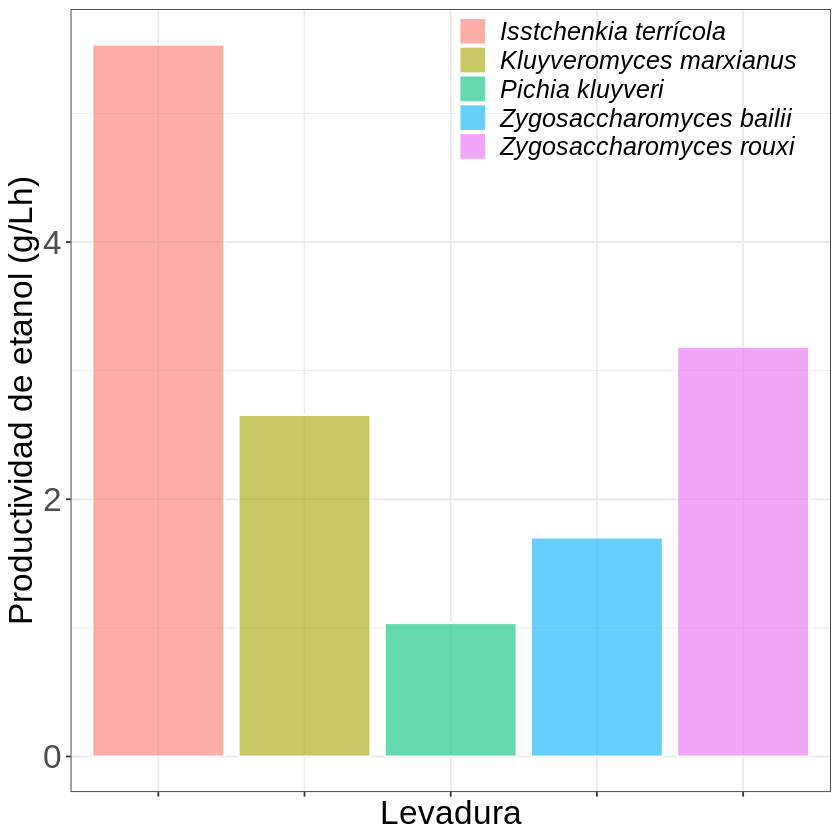

In [167]:
ggplot(data=data_mp, aes(x=lev, y=mp, fill = lev)) +
  geom_bar(stat="identity", color="white", alpha = 0.6) +
  xlab("Levadura") +
  ylab("Productividad de etanol (g/Lh)") +
  scale_fill_discrete(name = "", labels = c("Isstchenkia terrícola", 
  "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
  "Zygosaccharomyces rouxi")) +
  theme_bw() +
  theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            axis.text.x=element_blank(),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.73, 0.92), 
            legend.background = element_rect(fill=NA))
            

### Gráficas de productividad contra D

In [62]:
data_productivity_x <- data.frame(D = rep(x,5), productivity_x = c(productivity_it$productivity_x,productivity_km$productivity_x,
                            productivity_pk$productivity_x,productivity_zb$productivity_x,productivity_zr$productivity_x), 
                            lev = rep(c("IT","KM","PK","ZB","ZR"), each = length(x)))

Warning message:
“Removed 130 row(s) containing missing values (geom_path).”


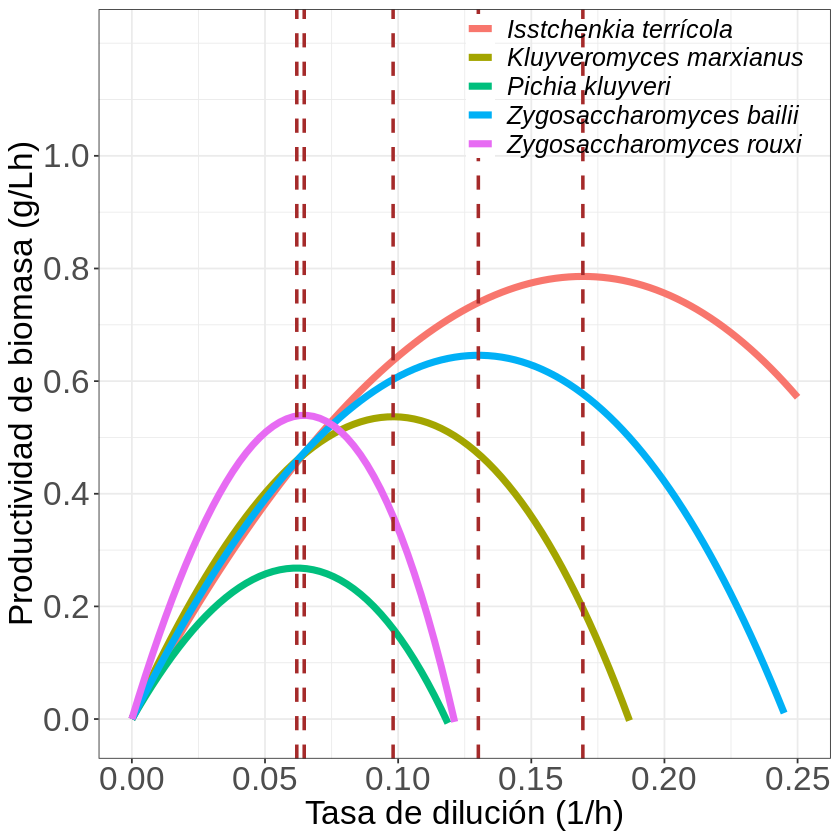

In [160]:
ggplot(data = data_productivity_x, aes(x = D, y = productivity_x, color = lev)) +
        geom_line(lwd = 2) +
        geom_vline(xintercept = sol_it$sol, col = "brown", lwd = 1, lty = 2) +
        geom_vline(xintercept = sol_km$sol, col = "brown", lwd = 1, lty = 2) +
        geom_vline(xintercept = sol_pk$sol, col = "brown", lwd = 1, lty = 2) +
        geom_vline(xintercept = sol_zb$sol, col = "brown", lwd = 1, lty = 2) +
        geom_vline(xintercept = sol_zr$sol, col = "brown", lwd = 1, lty = 2) +
        xlab("Tasa de dilución (1/h)") +
        ylab("Productividad de biomasa (g/Lh)") +
        theme_bw() +
        xlim(c(0,0.25))+
        scale_y_continuous(limits = c(-0.01, 1.2), breaks = seq(0,1,0.2)) +
        scale_color_discrete(labels=c("Isstchenkia terrícola", 
        "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
        "Zygosaccharomyces rouxi"))+
        theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.73, 0.92), 
            legend.background = element_rect(fill=NA))

In [86]:
data_productivity_p <- data.frame(D = rep(x,5), productivity_p = c(productivity_it$productivity_p,productivity_km$productivity_p,
                            productivity_pk$productivity_p,productivity_zb$productivity_p,productivity_zr$productivity_p), 
                            lev = rep(c("IT","KM","PK","ZB","ZR"), each = length(x)))

Warning message:
“Removed 133 row(s) containing missing values (geom_path).”


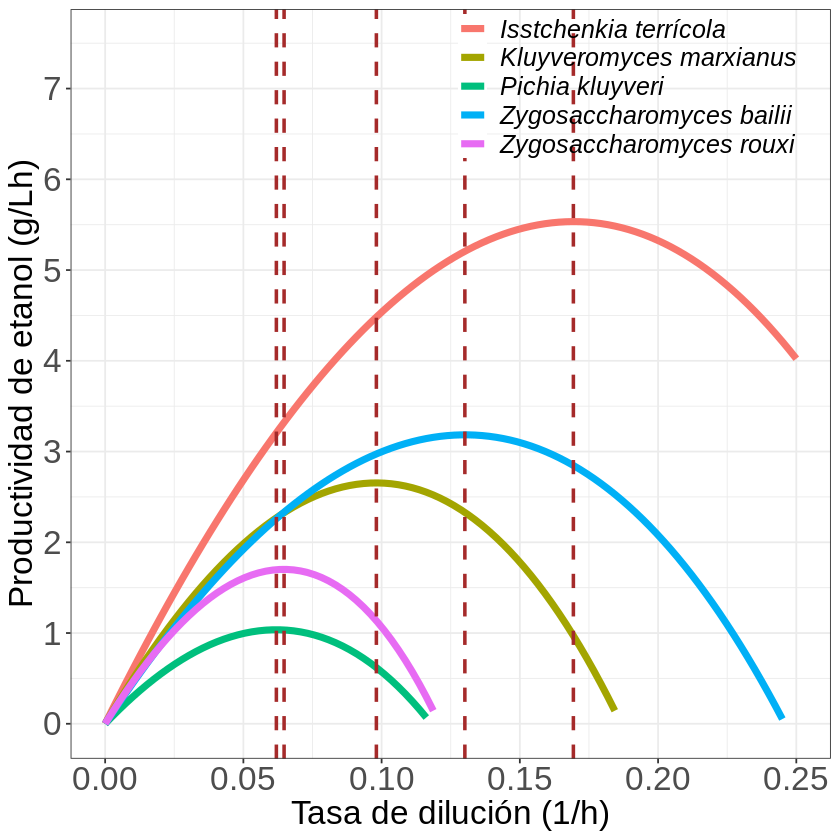

In [159]:
ggplot(data = data_productivity_p, aes(x = D, y = productivity_p, color = lev)) +
        geom_line(lwd = 2) +
        geom_vline(xintercept = sol_it$sol, col = "brown", lwd = 1, lty = 2) +
        geom_vline(xintercept = sol_km$sol, col = "brown", lwd = 1, lty = 2) +
        geom_vline(xintercept = sol_pk$sol, col = "brown", lwd = 1, lty = 2) +
        geom_vline(xintercept = sol_zb$sol, col = "brown", lwd = 1, lty = 2) +
        geom_vline(xintercept = sol_zr$sol, col = "brown", lwd = 1, lty = 2) +
        xlab("Tasa de dilución (1/h)") +
        ylab("Productividad de etanol (g/Lh)") +
        theme_bw() +
        xlim(c(0,0.25))+
        scale_y_continuous(limits = c(-0.01, 7.5), breaks = seq(0,7,1)) +
        scale_color_discrete(labels=c("Isstchenkia terrícola", 
        "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
        "Zygosaccharomyces rouxi"))+
        theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.73, 0.92), 
            legend.background = element_rect(fill=NA))

In [100]:
deriv_productivity_func(sol_it$sol, p_it)

[1] 0.004577044

In [101]:
sol_it$grad

[1] 0.004577044

In [102]:
f_x <- function(x) {
    f = x[1]^2 + x[1]*x[2] + 10*x[2]^2 - 5*x[1] - 3*x[2]
    return(f)
}

In [103]:
df_x <- function(x) {
    return(c(2*x[1] + x[2] - 5, x[1] + 20*x[2] - 3))
}

In [151]:
gradient_descent <- function(x0,alpha, N) {

    X = matrix(nrow = N, ncol = 2)
    i = 1
    grad = df_x(x0)
    while(i <= N) {
        x = x0 - alpha*grad
        X[i,] = x
        x0 = x
        grad = df_x(x0)
        i = i + 1
    }
    return(list(sol = X, grad = grad))
}

In [154]:
x0 = c(-3,-1)
alpha = 0.085
N = 100
sol3 = gradient_descent(x0, alpha, N)

In [155]:
sol3

-1.9800000,1.21000000
-1.3212500,-0.42370000
-0.6356230,0.66389625
-0.1589983,-0.15569942
0.3062659,0.37750445
0.6471128,-0.03528571
0.9651029,0.22469541
1.2069363,0.01567946
1.4254244,0.14143479
1.5960803,0.03483458
1.7467857,0.09494897


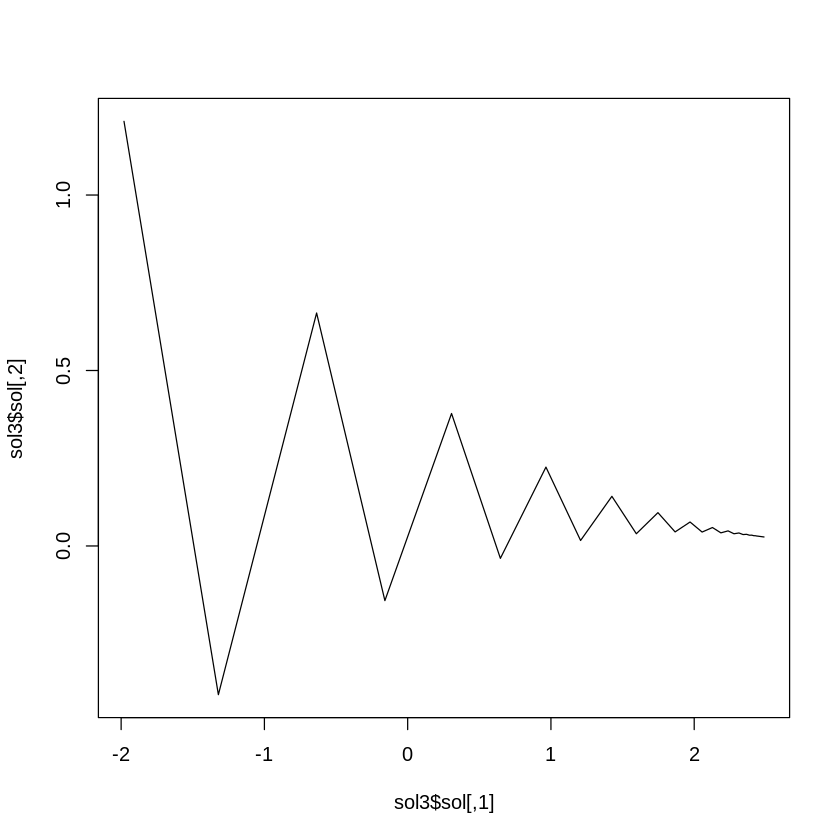

In [158]:
plot(sol3$sol, type = "l")